# AB-тест

## Описание задачи:
Для приложения был создан новый алгоритм подбора постов, которые будут показаны пользователю в ленте. Необходимо провести AB-тест, чтобы оценить эффективность нового алгоритма.  
  
Метрикой вовлеченности пользователя будет доля лайкнутых им постов от просмотренных постов(будем обозначать эту метрику как CTR, а рассчитывать как отношение количества лайков к количеству просмотров постов пользователем).

<b>Основная гипотеза:</b> алгоритм увеличивает вовлеченность пользователей.

 - Аудитория была разбита на 4 группы: 2 группа - контрольная, 1 группа - экспериментальная;
 - Данные для AB-теста собирались с '2022-11-02' по '2022-11-08'

In [1]:
import pandas as pd
import pandahouse as ph
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Получаем данные

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
SELECT user_id,
        exp_group,
        sum(action = 'like') as like,
        sum(action = 'view') as view,
        like/view as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-11-02' AND toDate(time) <= '2022-11-08'
GROUP BY user_id, exp_group
HAVING exp_group in (1, 2)
'''

df = ph.read_clickhouse(query, connection=connection)
df.head()

,user_id,exp_group,like,view,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,33,122,0.270492
4,18392,1,7,32,0.218750


#### Проверка данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20031 entries, 0 to 20030
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    20031 non-null  uint32 
 1   exp_group  20031 non-null  int8   
 2   like       20031 non-null  uint64 
 3   view       20031 non-null  uint64 
 4   ctr        20031 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 567.4 KB


Пропусков нет, типы данных корректны.

In [4]:
df.duplicated().sum()

0

Дублирующихся данных нет.

### Оценка групп

In [5]:
df.groupby('exp_group').user_id.count()

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

Размеры выборок будем считать приблизительно равными.

Проверим пересечение групп:

In [6]:
df.groupby('user_id', as_index=False).exp_group.nunique().query('exp_group > 1')

,user_id,exp_group


Пересечений между группами нет.

<b>Распределение CTR по группам</b>:

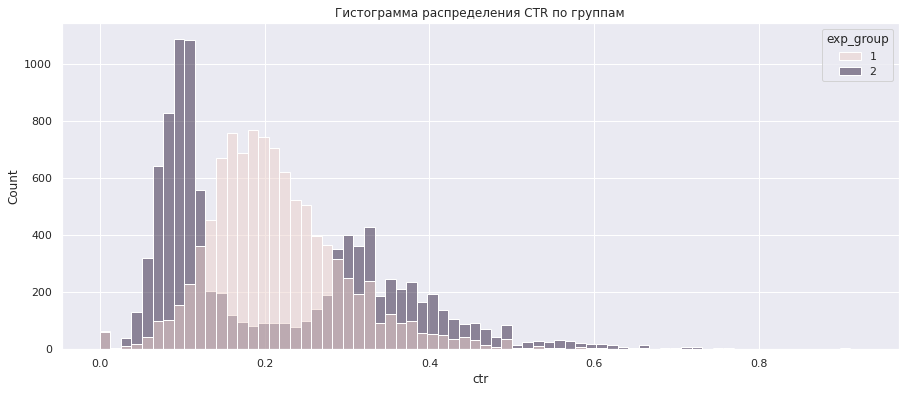

In [7]:
sns.set(rc = {'figure.figsize':(15,6)})
ax = sns.histplot(df[df['exp_group'].isin([1, 2])], x = 'ctr', hue = 'exp_group')
ax.set_title('Гистограмма распределения CTR по группам')
plt.show()

На гистограмме видно, что во второй группе распределение CTR не похоже на нормальное и бимодально. 

##### Возможная причина бимодальности распределния CTR во 2-ой группе:
Одно из возможных обяснений появления бимодального распределения в тестовой группе - применение алгоритма на пользователях с недостаточным количеством данных для качественного определения их предпочтений. В таком случае алгоритм будет выдавать не релевантные посты для пользователей с недостатком данных и наборот, будет увеличивать релевантность выдачи для пользователей с достаточным количеством данных.

### Тест Манна-Уитни

Т.к. сильно отклонение от нормальности может негативно отразится на точности t-теста, применим тест Манна-Уитни для оценки разницы между группами, разнообразие значений в каждой из выборок достаточно велико.

<b>Нулевая гипотеза:</b> Вероятность того, что CTR случайного пользователяо из 1 группы больше CTR пользователя из 2 группы, - 50%.  
<b>Альтернативная гипотеза:</b> Вероятность того, что CTR случайного пользователяо из 1 группы больше CTR пользователя из 2 группы, - не равна 50%.  
<b>Уровень значимости:</b> 0,05

In [8]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

p-value значительно ниже 0,05, поэтому мы принимаем альтернативную гипотезу.

По графику распределения видим, что вероятность получить более высокий  CTR выше в 1-ой(контрольной) группе.  
Сравним средние CTR-ы по групам.

In [9]:
df.groupby('exp_group').ctr.mean()

exp_group
1    0.215605
2    0.214419
Name: ctr, dtype: float64

Средний CTR в контрольной группе немного выше, но разница всего - 0,12%. При этом, как мы выяснили, для большинства польлзователй активность после применения нового алгоритма снижается, а для оставшихся - растет.

<b>Результат теста:</b> мы отклоняем нулевую гипотезу о независимости вероятности получить более высокий CTR в зависимости от группы. Вероятность получить более высокий CTR выше в первой(контрольной) группе.

## Пуассоновский бутстреп

Проведем также тест с помощью Пуассоновского бутстрепа, в рамках котрого сгенерируем 2000 подвыборок для каждой группы и найдем их ctr.

In [10]:
### Функция, возвращающая массивы ctr для сгенерированных подворок для групп.
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    #Для каждого пользователя герируем его вес в соответсвии с Пуассоновским распределением 2000 раз
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [11]:
### Применяем функцию к нашим данным
likes1 = df[df.exp_group == 1].like.to_numpy()
views1 = df[df.exp_group == 1].view.to_numpy()
likes2 = df[df.exp_group == 2].like.to_numpy()
views2 = df[df.exp_group == 2].view.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

Посмотрим получившиеся распределения CTR с помощью столбчатой гистограммы:

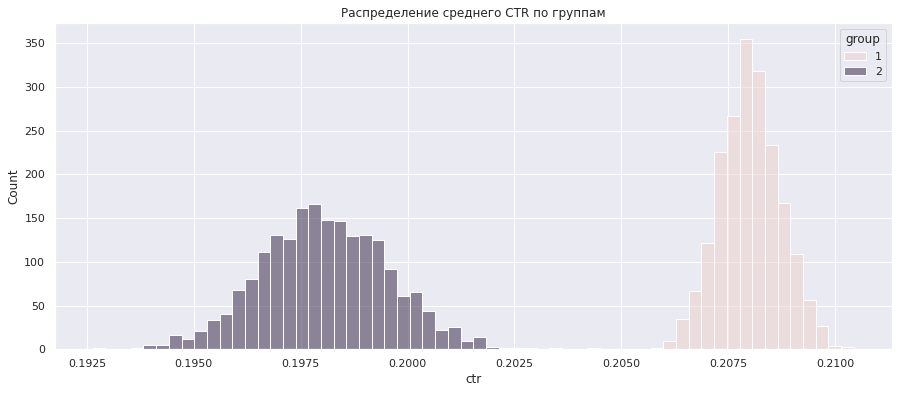

In [12]:
bs_df = pd.DataFrame({
    'group': np.concatenate((np.array([1 for i in ctr1]), np.array([2 for i in ctr2]))),
    'ctr':np.concatenate((ctr1, ctr2))
})

ax = sns.histplot(data=bs_df, x='ctr', hue='group', bins=60)
ax.set_title('Распределение среднего CTR по группам')
plt.show()

<b>Выводы:</b> во всех сгенерированных подвыборках средний CTR контрольной группы выше, чем в контрольной группе, что подкрепляет результаты теста Манна Уитни.

### Рекомендации

 - Средний CTR в контрольной группе немного выше: разница всего - 0,12%. При этом, как мы выяснили, для большинства польлзователй активность после применения нового алгоритма снижается, а для оставшихся - растет.
 - Мы не рекомендуем применять новый алгоритм ко всем пользователям, он снижает вовлеченность большинства пользователей.
 - Также рекомендуем провести дополнительное исследование причин бимодальности распределения CTR в контрольной группе. Одна из возможных причин - прменение алгоритма на пользователях с недостаточным количеством данных для качественного определения их предпочтений.